#           Delta-Gamma hedging of the american put option with a Neural net.

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import time
from tensorflow.keras import layers

In [3]:
tf.random.set_seed(10)

## Hull 20.8

## Using the 'finite method PDE' to value an American put option on a non-dividend paying stock.

## $$\frac{\partial f}{\partial t}+r\frac{\partial f}{\partial S} + \sigma^2 S^2\frac{\partial^2 f}{\partial S^2} = rf$$
## Where $r$ and $\sigma$ are the risk-free rate and volatility, respectively. It is assumed that they will be constant through out.

## Boundary equations:
## $$f(T,S)=\mbox{ Max }({K-S},0)$$
## $$f(t,0)=K$$
## $$f(t,S_{max})=0$$
## Where T and K are maturity date and strike prize respectively.

In [4]:
N_t = 100
N_s = N_t
r = 0.1
sigma = 0.4
so = 50.
k = 50
t = np.linspace(0,5, N_t, dtype = np.float32).reshape(N_t,1)
s = np.linspace(0,100, N_s, dtype = np.float32).reshape(N_s,1)

In [5]:
smax = s.max()
tmax = t.max()

In [6]:
t = t/t.max()
s = s/s.max()

In [7]:
k = tf.convert_to_tensor(k, dtype=tf.float32)/smax   #normalize
r = tf.convert_to_tensor(r, dtype=tf.float32) 
sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)
so = tf.convert_to_tensor(so, dtype=tf.float32)
t = tf.convert_to_tensor(t, dtype=tf.float32) 
s = tf.convert_to_tensor(s, dtype=tf.float32) 

In [8]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel,self).__init__()
        #activation = 'sigmoid', 
        self.dense1 = layers.Dense(200, input_shape = (3,))
        self.dense2 = layers.Dense(100)
        self.dense3 = layers.Dense(50)
        self.dense4 = layers.Dense(25)
        self.dense5 = layers.Dense(25)
        self.dense6 = layers.Dense(20)
        self.dense7 = layers.Dense(20)
        self.dense8 = layers.Dense(20)
        self.dense9 = layers.Dense(1)
        
    def call(self, x):
        x = self.dense1(x)
        x = tf.nn.tanh(x)

        x = self.dense2(x)
        x = tf.nn.tanh(x)
        
        x = self.dense3(x)
        x = tf.nn.tanh(x)

        x = self.dense4(x)
        x = tf.nn.tanh(x)

        x = self.dense5(x)
        x = tf.nn.tanh(x)

        x = self.dense6(x)
        x = tf.nn.tanh(x)

        x = self.dense7(x)
        x = tf.nn.tanh(x)
        
        x = self.dense8(x)
        x = tf.nn.tanh(x)
        
        x = self.dense9(x)
        x = tf.nn.tanh(x)
        
        return x

In [9]:
model = MyModel()

In [10]:
def u(t,s,k):
    return model(tf.concat([t,s,k*tf.ones(s.shape)],1))

In [11]:
@tf.function
def f(t,s,k):
    t = tf.Variable(t, dtype = tf.float32)
    s = tf.Variable(s, dtype = tf.float32)
    with tf.GradientTape() as der2:
        with tf.GradientTape(persistent=True) as der1:
            u_ = u(t,s,k)
        u_t = der1.gradient(u_, t)
        u_s = der1.gradient(u_, s)
    u_ss = der2.gradient(u_s, s)
    f = u_t + r*u_s + (sigma**2)*0.5**u_ss
    return f

In [12]:
@tf.function
def loss(t,s):
    #|u(0,t)-k|^2
    mse_y_0 = tf.reduce_mean(tf.square(u(t,tf.zeros(s.shape),k)-k))
    #|u(smax,t)|^2 u(t,s)
    mse_yp_0 = tf.reduce_mean(tf.square(u(t,smax*tf.ones(s.shape),k)))
    #|u(s,tmax)-max(k-s,0)|^2
    mse_eq = tf.reduce_mean(tf.square(u(tmax*tf.ones(s.shape),s,k)-tf.maximum(k-s,0)))
    mse_t = mse_eq + mse_y_0 + mse_yp_0  #MSE tota;
    return mse_t

In [13]:
@tf.function
def loss_option(t,s,option):
    #|u(0,t)-k|^2
    mse_y_0 = tf.reduce_mean(tf.square(u(t,tf.zeros(s.shape))-k))
    #|u(smax,t)|^2 u(t,s)
    mse_yp_0 = tf.reduce_mean(tf.square(u(t,smax*tf.ones(s.shape))))
    #|u(s,tmax)-max(k-s,0)|^2
    if option == 'p':
        print('put')
        mse_eq = tf.reduce_mean(tf.square(u(tmax*tf.ones(s.shape),s)-tf.maximum(k-s,0)))
    else:
        print('call')
        mse_eq = tf.reduce_mean(tf.square(u(tmax*tf.ones(s.shape),s)-tf.maximum(s-k,0)))
        
    mse_t = mse_eq + mse_y_0 + mse_yp_0  #MSE tota;
    return mse_t

In [14]:
loss(t,s)

<tf.Tensor: id=598, shape=(), dtype=float32, numpy=0.6615121>

In [23]:
los = loss(t,s)

In [27]:
optim = tf.keras.optimizers.Adam(0.001)

In [28]:
@tf.function
def train_step(t,s):
    with tf.GradientTape() as g:
        los = loss(t,s)
        
    dldparams = g.gradient(los, model.trainable_variables)
    
    optim.apply_gradients(zip(dldparams,model.trainable_variables))
    return los

In [29]:
train_step(t,s)

<tf.Tensor: id=2034, shape=(), dtype=float32, numpy=0.6615121>

In [30]:
#model.load_weights('BSM_with_k')

In [31]:
loss(t,s)

<tf.Tensor: id=2035, shape=(), dtype=float32, numpy=0.5456176>

In [32]:
start_time1 = time.time()
tn = tf.random.shuffle(t,seed=10)
sn = tf.random.shuffle(s,seed=10)
epochs = 5000
losss = 0.
draw =[]
batch_size = 20
batches = int(t.shape[0]/batch_size)


print('Initial loss: ',loss(t,s).numpy())
for epoch in range(epochs):
    start = 0
    for i in range(batches):
     #   print('start',start,'end',start + batch_size)
    #    print(model(x[start:start + batch_size]),'\n')
   #     print('train:',train_step(x[start:start + batch_size]).numpy())
        losss = train_step(tn[start:start + batch_size],sn[start:start + batch_size])
        draw.append(losss)     
        start +=batch_size
    if epoch%100== 0:
        print('Epoch #{} loss is {}'.format(epoch, losss))
        if(np.abs(draw[-2]-draw[-1])<=1e-15):
            break
finish1 = time.time()        
diff1=finish1-start_time1
print(int(diff1/(60*60)),'hours',int((diff1)/60),'minutes',int(diff1%60),'secs')              

Initial loss:  0.5456176
Epoch #0 loss is 0.06917542964220047
Epoch #100 loss is 0.0001272210938623175
Epoch #200 loss is 0.00015944229380693287
Epoch #300 loss is 0.00011559935956029221
Epoch #400 loss is 0.00010868377285078168
Epoch #500 loss is 0.00012697627244051546
Epoch #600 loss is 3.8219281123019755e-05
Epoch #700 loss is 1.818667442421429e-05
Epoch #800 loss is 0.0001505240797996521
Epoch #900 loss is 0.00010659465624485165
Epoch #1000 loss is 3.2702733733458444e-05
Epoch #1100 loss is 7.788001676090062e-05
Epoch #1200 loss is 1.3767519703833386e-05
Epoch #1300 loss is 9.036156552610919e-05
Epoch #1400 loss is 2.5441795514780097e-05
Epoch #1500 loss is 9.521371976006776e-05
Epoch #1600 loss is 4.287277624825947e-05
Epoch #1700 loss is 5.9883295762119815e-05
Epoch #1800 loss is 7.483393710572273e-05
Epoch #1900 loss is 2.488469544914551e-05
Epoch #2000 loss is 2.6158933906117454e-05
Epoch #2100 loss is 9.004946150525939e-06
Epoch #2200 loss is 3.977510459662881e-06
Epoch #2300 

In [33]:
loss(t,s)

<tf.Tensor: id=227836, shape=(), dtype=float32, numpy=1.7674795e-06>

Text(0.5, 0, 'iterations')

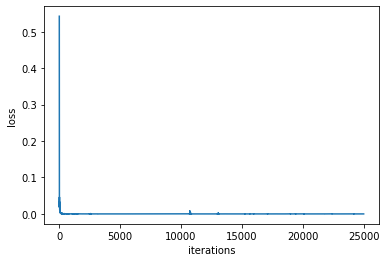

In [35]:
plt.plot(draw)
plt.ylabel('loss')
plt.xlabel('iterations')

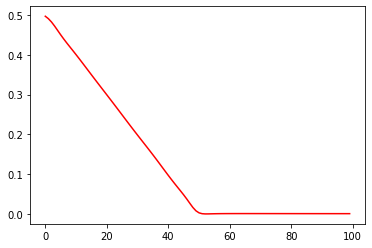

In [36]:
plt.plot(u(tmax*tf.ones(t.shape),s,k), 'r', label = 'model')

In [37]:
# Quasi Newton to improve the result
shapes = tf.shape_n(model.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)

def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        model.trainable_variables[i].assign(tf.reshape(param, shape))

def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights) 

@tf.function
def value_and_gradient(flat_weights):
    #update weights 
    update_weights(flat_weights)
    with tf.GradientTape() as g:
        los = loss(t,s)
        
    grad = g.gradient(los, model.trainable_variables) 
    flattend_grad = flatten_the_parameters(grad) #converts from multDim to 1D
    return los, flattend_grad

start_time2 = time.time()

flat_parameters = flatten_the_parameters(model.get_weights())
start = tf.constant(flat_parameters)  # Starting point for the search.

optim_results = tfp.optimizer.lbfgs_minimize(
  value_and_gradient, initial_position=start, tolerance=1.0e-20, max_iterations=5000)
print('converged:', optim_results.converged.numpy())
update_weights(optim_results.position)
print('loss',loss(t,s))
finish2 = time.time()
diff2=finish2-start_time2
print(int(diff2/(60*60)),'hours',int((diff2)/60),'minutes',int(diff2%60),'secs')    

converged: False
loss tf.Tensor(5.486593e-08, shape=(), dtype=float32)
0 hours 2 minutes 27 secs


In [38]:
loss(t,s)

<tf.Tensor: id=529142, shape=(), dtype=float32, numpy=5.486593e-08>

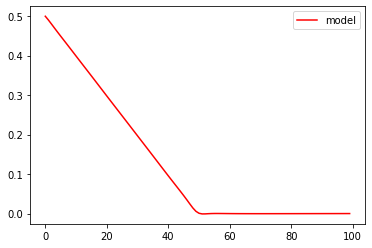

In [39]:
plt.plot(u(tmax*tf.ones(t.shape),s,k), 'r', label = 'model')
#plt.plot(x,y(x), 'b-', label = 'theory')
plt.legend(loc='best')

In [40]:
model.save_weights('BSM_with_k')

Text(0.5, 1.0, '$\\Delta_p$ the put option')

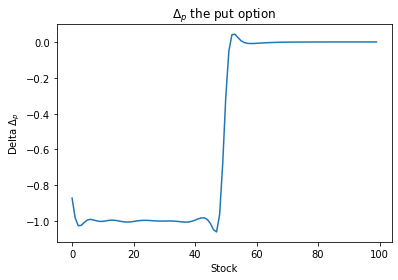

In [43]:
S = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape() as dg:
    v = u(tmax*tf.ones(t.shape),S,k)
delta = dg.gradient(v,S)

plt.plot(delta)
plt.ylabel('Delta $\Delta_p$')
plt.xlabel('Stock')
plt.title('$\Delta_p$ the put option')
# plt.ylim(0,0.01)

### The above agrees with theory,  $\Delta$ for a put option is between -1 and 0.

## Delta neutral

### So far our portfolio,X, consist of a single put option. To make X $\Delta$-neutral we must have the following condition $$\Delta_x = \frac{\partial X}{\partial S} = 0$$  S is the underlying stock. 

### A put option has a $\Delta_p < 0$. To make $\Delta_x = 0$,  our portfolio X must include $N_s$ stocks. Since  $\Delta_s > 0$. The portfolio now consist of a put(p) and a stock(s).

### The value,$V$, of our portfolio is $$V = N_p P + N_s S$$  Where $N_p \mbox{and} N_s$ are the number of put options and shares in V. In our case $N_p =10$ and our aim is to find $N_s$ that makes V delta-neutral.

### $$0 = \frac{\partial V}{\partial S} = N_{p}\frac{\partial P }{\partial S} + N_s$$
###  $$\frac{\partial P }{\partial S} = \Delta_p = -\frac{N_s}{N_p}$$
### Therefore $$N_s = -N_p\Delta_{p} = -10\Delta_p$$
### $N_s$ is the number of shares needed to make the portfolio $V$ delta neutral.

### Determining $N_s$

In [46]:
Np = 10
Ns = -Np*delta

## New portfolio $$V = 10P + NsS$$

In [47]:
v = Np*u(tmax*tf.ones(t.shape),s,k)+Ns*s

## Check if $\Delta_V = 0$

Text(0.5, 1.0, 'Delta for the new portfolio V')

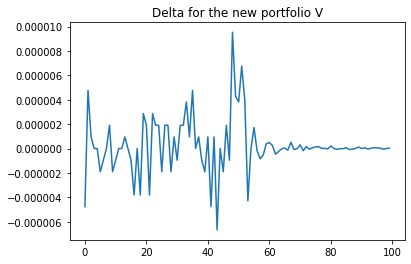

In [48]:
St = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape() as dg:
    v = 10*u(tmax*tf.ones(t.shape),St,k)+Ns*St
    delta_neutral = dg.gradient(v,St)
plt.plot(delta_neutral)
plt.title('Delta for the new portfolio V')

## $\Delta_V$ is sufficiently close to zero. Portfolio,V, is delta neutralized ;)

### $\Delta_V \approx 0$ throughout. Portfolio V is not affected by small changes of the stock.  But what if we have large changes of the stock price?$\Delta_V$ will not be able to account for it.  For instance, suppose that,locally, the option price $P$ is a quadratic function of the stock price $S$. Then $\Delta_V$ approximates this function as a straight line at $S_0$ - ignores the curvature. It will be correct for very small changes of the stock price but will fail to account large changes. 

### $\Gamma_V$ helps us solve this problem. Because is defined by $$\Gamma_V = \frac{\partial^2 V}{\partial^2 S} = \frac{\partial \Delta_V}{\partial S} $$ thus considers curvature that $\Delta_V$ missed.

Text(0.5, 0, 'S')

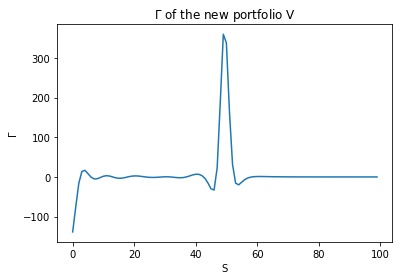

In [50]:
S = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape() as dg2:
    with tf.GradientTape() as dg1:
        v = 10*u(tmax*tf.ones(t.shape),S,k)+Ns*S
    dvds = dg1.gradient(v,S)
gamma_v = dg2.gradient(dvds,S)   
plt.plot(gamma_v)
plt.title('$\Gamma$ of the new portfolio V')
plt.ylabel('$\Gamma$')
plt.xlabel('S')

## Gamma neutral

## $$\Gamma = \frac{\partial \Delta}{\partial S}$$
### $\Gamma$ depends on $\Delta \mbox{ and }S$. By changing $\Delta$ we can manipulate $\Gamma$.  V consist of a put option that has $\Delta_p <0$. and some stocks. We have to add an instruments that  will neutralize $\Gamma_V$. Since we have solved for the put option, we will add another a put option with a different strike price. Inside $V$ Our new portfolio becomes  
## $$V = N_{p1} P(k_1) + N_s S + N_{p2} P(k_2)$$

## $$\Delta_V =  N_{p1}\Delta_1+ N_s +N_{p2}\Delta_2$$
## $$\Delta_i = \frac{\partial P(k_1)}{\partial S}, i = 1,2$$


## $$\Gamma_V = \frac{\partial^2 V}{\partial S^2} = N_{p1}\Gamma_1+N_{p2}\Gamma_2$$
## $$\Gamma_i = \frac{\partial P(k_i)}{\partial S^2}, i = 1,2$$
## Aim $$\Gamma_V = 0$$


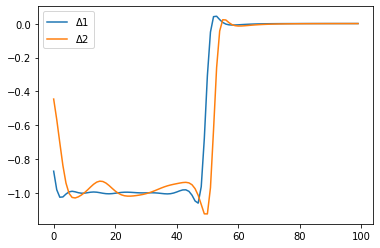

In [51]:
#k2 = 2*k1
S = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape(persistent=True) as dg2:
    with tf.GradientTape(persistent=True) as dg:
        v1 = u(tmax*tf.ones(t.shape),S,k)
        v2 = u(tmax*tf.ones(t.shape),S,2*k)
    delta1 = dg.gradient(v1,S)
    delta2 = dg.gradient(v2,S)
gamma1 =  dg2.gradient(delta1,S)   
gamma2 =  dg2.gradient(delta2,S)
plt.plot(delta1,label='$\Delta1$')
plt.plot(delta2,label='$\Delta2$')
plt.legend(loc='best')

In [53]:
np2 = -Np*gamma1/gamma2
v_g = Np*u(tmax*tf.ones(t.shape),s,k) + Ns*s + np2*u(tmax*tf.ones(t.shape),S,2*k)

Text(0.5, 0, 'S')

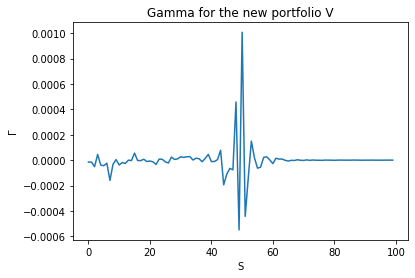

In [56]:
St = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape() as dg2:
    with tf.GradientTape() as dg:
        v_g = Np*u(tmax*tf.ones(t.shape),St,k) + Ns*St + np2*u(tmax*tf.ones(t.shape),St,2*k)
    delta_neutral = dg.gradient(v_g,St)
gamma_neutral =dg2.gradient(delta_neutral,St)     
plt.plot(gamma_neutral)
plt.title('Gamma for the new portfolio V')
plt.ylabel('$\Gamma$')
plt.xlabel('S')

### Introducing another put in the portfolio changes delta of V. This makes our portfolio delta not zero. It needs to be re-adjusted.

Text(0.5, 1.0, 'Delta for the new portfolio V_g')

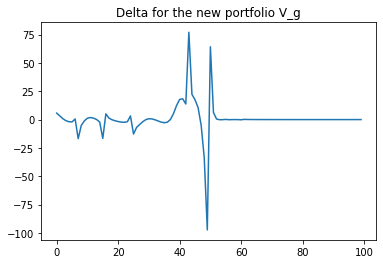

In [57]:
plt.plot(delta_neutral)
plt.title('Delta for the new portfolio V_g')

In [63]:
Ns_2 = -(Np*delta1)-np2*delta2

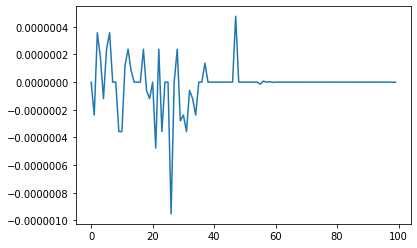

In [64]:
plt.plot(Np*delta1+(Ns_2)+np2*delta2)

### $\Delta_V = 0$ as required.

## That's it.  We have now managed to neutral delta and gamma.

## Simple way:
## We can do delta-gamma hedge at the same time.

## $$\Delta_V =  N_{p1}\Delta_1+ N_s +N_{p2}\Delta_2$$
## $$\Gamma_V = \frac{\partial^2 V}{\partial S^2} = N_{p1}\Gamma_1+N_{p2}\Gamma_2$$
## Delta-gamma neutral:
## $$N_{p1}\Delta_1+ N_s +N_{p2}\Delta_2 = 0$$
## $$\frac{\partial^2 V}{\partial S^2} = N_{p1}\Gamma_1+N_{p2}\Gamma_2 = 0$$
## Solving for  $N_{p1} \mbox{ and } N_{p2}$ we get
## $$N_{p1} = -\frac{N_s}{\Gamma_{2}\Delta_{1} - \Gamma_{1}\Delta_{2}}$$
## $$N_{p2} = - \frac{N_{p1}\Gamma_{1}}{\Gamma_{2}}$$
## Then substitute in $$V = N_{p1} P(k_1) + N_s S + N_{p2} P(k_2)$$

In [77]:
np1 = -(Ns*gamma2)/(gamma2*delta1 - gamma1*delta2)
np2 = -np1*gamma1/gamma2
v_final = np1*u(tmax*tf.ones(t.shape),s,k) + Ns*s + np2*u(tmax*tf.ones(t.shape),s,2*k)

In [78]:
S = tf.Variable(s, dtype=tf.float32)
with tf.GradientTape() as g2:
    with tf.GradientTape() as g1:
        v_final = np1*u(tmax*tf.ones(t.shape),S,k) + Ns*S + np2*u(tmax*tf.ones(t.shape),S,2*k)
    delta_final = g1.gradient(v_final,S)
gamma_final =  g2.gradient(delta_final,S)   

Text(0.5, 1.0, '$\\Delta_V$ for two put options')

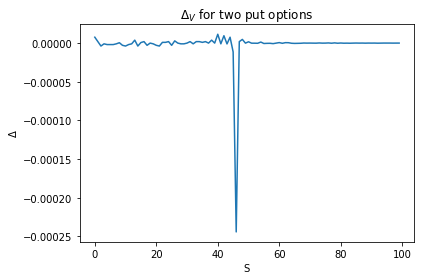

In [79]:
plt.plot(delta_final)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.title('$\Delta_V$ for two put options')

Text(0.5, 1.0, '$\\Delta_V >0 $ for two put options ')

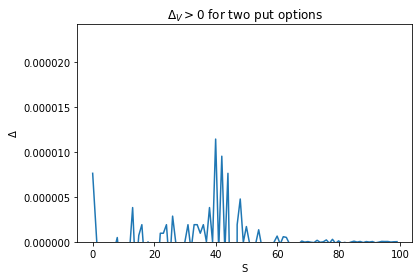

In [80]:
plt.plot(delta_final)
plt.ylim(0,)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.title('$\Delta_V >0 $ for two put options ')

Text(0.5, 1.0, '$\\Gamma_V >0 $ for two put options ')

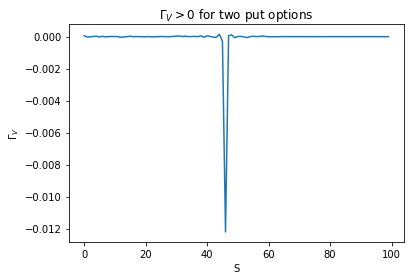

In [81]:
plt.plot(gamma_final)
plt.xlabel('S')
plt.ylabel('$\Gamma_V$')
plt.title('$\Gamma_V >0 $ for two put options ')

Text(0.5, 1.0, '$\\Gamma_V >0 $ for two put options ')

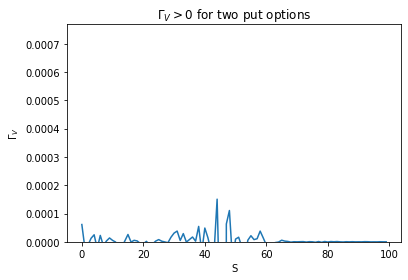

In [82]:
plt.plot(gamma_final)
plt.ylim(0,)
plt.xlabel('S')
plt.ylabel('$\Gamma_V$')
plt.title('$\Gamma_V >0 $ for two put options ')

### From the above graphs, we can conclude that the portfolio has been delta-gamma hedged.

## References
1. Hedging with Options (MMA707) School of Education, Culture and Communication Tutor: Jan Röman
2. https://www.quora.com/What-is-the-difference-between-delta-and-gamma-hedging
3. John Hull 8th edition
4. Valuing and Hedging American Put Options: Using Neural Networks David L. Kelly 
5. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations